# WIRC+Pol Data Reduction Tutorial #
Welcome to the WIRC+Pol data reduction pipeline (DRP) tutorial. The notebook will give you a basic run 
through of how to reduce WIRC+Pol data and give you some details about the setup of the pipeline. 


### Pipeline Description ###
The pipeline has been designed so that once read-in, each data file will be held in an object called a *wirc_data* object. Each *wircpol_data* object will contain, the raw (or calibrated) 2D data itself, relevant information about the data and a number of functions that will calibrate and process the data. It will also contain a list of *wircpol_source* objects, where each *wircpol_source* will correspond to a source in the field. The source object will contain thumbnails of the spectral traces, as well as the extracted spectrum and polarized spectrum for each source.

Note: The current implementation has been designed with WIRC+Pol data in mind, but we hope to extent this to WIRC+Spec data soon. 

### Assumptions ###
We assume that you have set an environment variable called "WIRC_DRP" that points to the base directory of the DRP and that it is in your python path. Beyond the standard python packages we also assume you have astropy installed. 

The pipeline also requires the installation of image registration tools found here:https://github.com/keflavich/image_registration
To Install, clone the repository and run the setup.py from a terminal:
>python setup.py install

### The Tutorial ### 
This tutorial will give an example of reducing a raw WIRC+Pol data image from start to finish, and will give you an idea of the implementation of the pipeline along the way. We'll note that many of the later data reduction steps (e.g. spectral extraction) are works in progress, and so the final data products should not yet be used for science. The purpose of this tutorial is more to demonstrate the features of the pipeline rather than to teach you how to fully calibrate your data. 



## The Recipe

There are several steps to reducing polarimetric data, some in common with typical photometry data reduction and some not. Here is a brief list of steps.

(1) Correct for detector dark current and pixel-to-pixel variation by subtracting dark and dividing flat. 

(2) Source identification. The DRP has a capability to detect a source in the image. Alternatively, the pixel coordinates of the source can be manually entered. The DRP then grabs the 4 spectral traces associated with the source from the calibrated science image. 

(3) Subtract background from the data. There are multiple ways to do this, but in this tutorial we will simply use the shifted science image for background subtraction.

(4) Spectral extraction. In this step we extract 1D spectra from the 4 spectral traces, which correspond to 4 different linear polarization angles. After finishing steps (2) to (4) for both the unpolarized standard star and the source, you can proceed to the next step. 

(5) Stack spectra. We can now combine the whole observing sequence to increase SNR before we compute the polarization.

(6) Polarimetric calibration. Raw polarization measurement from WIRC+Pol is incorrect by several percent, but we can remove this offset by an observation of a known unpolarized star. We apply the correction in this step to measure polarization intrinsic to the source. 


## Step 0 - Make your calibration files ##
The very first step will be to create your own master darks and master flats. For the sake of this tutorial we well assume that you have done this already, but we provide somed example code commented-out below. Already-made master darks and flats have been provided in the tutorial directory. 

In [1]:
#Import the important things
%matplotlib inline
%load_ext autoreload
%autoreload 2
import wirc_drp.wirc_object as wo
from wirc_drp.utils import calibration, spec_utils as su, image_utils as iu
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii as asci
import os, copy
from scipy.ndimage import shift

In [2]:
tutorial_dir = os.getcwd()

##### Create a master dark #####
First you will need a list of files that will go into the master dark. It can be created like this: 

__bash> ls wirc{xxxx..yyyy}.fits > dark_list_1s_1coadd.dat__

where __xxxx__ and __yyyy__ are the first and last file numbers of the dark sequence. Repeat this for every combination of exposure time and coadds. (If you're not running bash and the {xxxx..yyyy} notation doesn't work, try __/bin/bash__ in the terminal. 

Then you read it in and create your mater dark by taking the median of all the files in the list. A hotpixel map will also be generated by default.  

In [3]:
# ### First set your data directory

# data_dir =  
# calib_dir = 

# os.chdir(data_dir)
# ### Get the file list 


# #1 second, 10 coadds (for unpolarized standard and flats)

# dark_list_fn = "dark_10_1.0s.list" #The file name for your list of dark files
# dark_list1s_10 = (asci.read(dark_list_fn, format = 'fast_no_header'))['col1'] #Read in the list

# dark_name1s_10, bp_name1s_10 = calibration.masterDark(dark_list1s_10) # The output of this function is a the filename 
#                                                            # of the master dark and bad pixel maps

# #60 second, 1 coadd (for brown dwarf)
# dark_list_fn = "dark_1_60.0s.list" #The file name for your list of dark files
# dark_list60s_1 = (asci.read(dark_list_fn, format = 'fast_no_header'))['col1'] #Read in the list

# ## Create the master dark and a bad pixel map.
# ## This function creates a new fits file based on the last filename in your dark_list and appends "_master_dark.fits"
# ## The hot pixel map will be the same, except with a "_bp_map.fits" suffix. 
# dark_name60s_1, bp_name_60s_1 = calibration.masterDark(dark_list60s_1) # The output of this function is a the filename 
#                                                            # of the master dark and bad pixel maps

##### Create a master flat #####
First you will need a list of files that will go into the master flat. It can be created like this: 

__bash> ls wirc{xxxx..yyyy}.fits > flat_list_J.dat__

where __xxxx__ and __yyyy__ are the first and last file numbers of the flat sequence. Repeat this for every broadband filter.

Then you read it in and create your mater flat by subtracting the master dark from each image, taking the median of all the files in the list and then normalize by either the median (default) or the mode, set by the *normalize* keyword. A bad pixel map will also be generated by default, which you can supplement with the hot pixel map output by creating the master dark. 

In [4]:
# ### Get the file list 
# flat_list_fname = "flat_J.list" #The file name for your list of flat files
# flat_list = (asci.read(flat_list_fname, format = 'fast_no_header'))['col1']

# ### Create the master dark and a bad pixel map. You will need the filename of the dark of the same exposure time.
# ### This function creates a new fits file based on the last filename in your flat list and appends "_master_flat.fits"

# flat_name, bp_name = calibration.masterFlat(flat_list, dark_name1s_10, hotp_map_fname = bp_name1s_10) 


Now you have all calibration files needed to reduce your science exposures. 

For this Tutorial, we will use pre-processed calibration files

In [5]:
os.chdir('./sample_data/')

In [6]:
flat_name = 'wirc0627_master_flat.fits'
bp_name = 'wirc0627_bp_map.fits'
dark_name1s_10 = 'wirc0648_master_dark.fits'
dark_name60s_1 = 'wirc0711_master_dark.fits'

## Step 1 - Read in and calibrate your data ##
Assuming that you now have a master dark and master flat file, we can now read in a wirc_data file and perform the calibration. 

In [7]:
#First we'll set up all the directories and filenames: 
unpol_filelist = 'HD11639_sci.list' #for the unpolarized standard
#source_filelist = 'SIMP0136_sci.list' #for the source, the brown dwarf here

#Read in the file names
unpol_fnames  = asci.read(unpol_filelist , format = 'fast_no_header')['col1']
#source_fnames = asci.read(source_filelist, format = 'fast_no_header')['col1']


First we deal with the unpolarized standard star. We will demonstrate the process for one file, then loop through and calibrate everything. 

In [8]:
#Choose dark with the correct exposure time here
dark_fn = dark_name1s_10
#Then select flat and bad pixels map
flat_fn = flat_name
bp_fn   = bp_name

#Now we'll create the wirc_data object, passing in the filenames for the master dark, flat and bad pixel maps
raw_data = wo.wirc_data(raw_filename=unpol_fnames[0], flat_fn = flat_fn, dark_fn = dark_fn, bp_fn = bp_fn)

Creating a new wirc_data object from file wirc0140.fits
Found a J-band filter in the header of file wirc0140.fits


The wirc_data object holds the 2D data image in the property full_image. We can take a look at it now: 

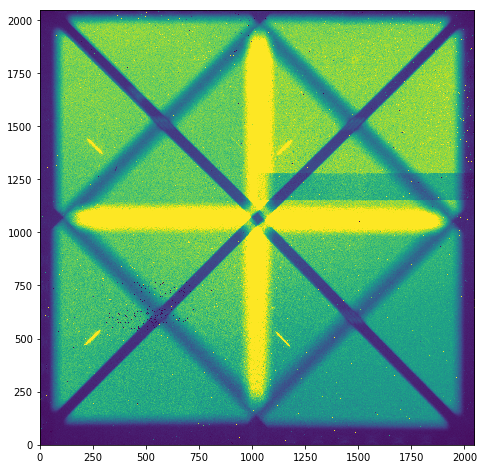

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(raw_data.full_image, vmin=0, vmax=5000, origin = 'lower')

We can see (even in this zoomed out image) that there are a bunch of bad pixels. Let's run the calibration step. It will subtract the dark, divide by the flat, and interpolate over the bad pixels. 

In [10]:
raw_data.calibrate(mask_bad_pixels=False)

Subtracting wirc0648_master_dark.fits from the image


/Users/kaew/work/wircpol/wirc_drp/wirc_drp/wirc_object.py:186: RuntimeWarning: invalid value encountered in true_divide
  self.full_image = self.full_image/master_flat
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/calibration.py:724: RuntimeWarning: invalid value encountered in less_equal
  bad_pixel_map = np.logical_or(bad_pixel_map, redux_science <= 0)


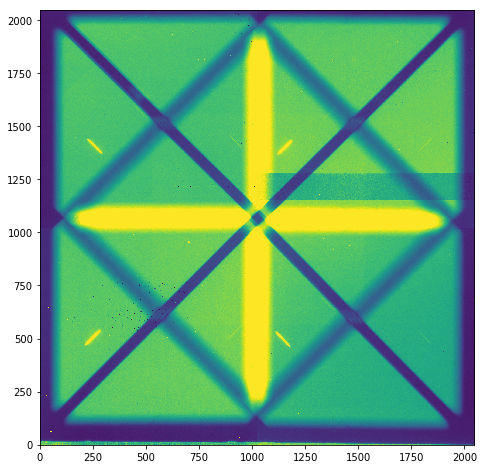

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(raw_data.full_image, vmin=0, vmax=5000, origin = 'lower')

There are a few remaining artifacts in the image, but overall, not bad! 

Now we can loop through all the files and calibrate them!

In [12]:
######Set the calibration output directory. Set this up for your own group!!!#####
calib_dir = tutorial_dir+'/sample_data/'

unpol_calibrated_list = np.array([]) #This is a list of the calibrated files.


#Read in the file names
unpol_fnames  = asci.read(unpol_filelist , format = 'fast_no_header')['col1']
#source_fnames = asci.read(source_filelist, format = 'fast_no_header')['col1']

for i, fn in enumerate(unpol_fnames):
    #open the file
    raw_data = wo.wirc_data(raw_filename=unpol_fnames[i], flat_fn = flat_fn, dark_fn = dark_fn, bp_fn = bp_fn)
    #run the calibration
    raw_data.calibrate(mask_bad_pixels=False)
    #file name of the calibrated file
    outname = fn.split('.')[0]+'_calib.fits'
    #add to the list and save it
    unpol_calibrated_list = np.append(unpol_calibrated_list, calib_dir+outname)
    raw_data.save_wirc_object(calib_dir+outname)
    
#save the list, just in case
np.save(calib_dir+'unpol_calibrated_list.npy', unpol_calibrated_list)
    

Creating a new wirc_data object from file wirc0140.fits
Found a J-band filter in the header of file wirc0140.fits
Subtracting wirc0648_master_dark.fits from the image


/Users/kaew/work/wircpol/wirc_drp/wirc_drp/wirc_object.py:186: RuntimeWarning: invalid value encountered in true_divide
  self.full_image = self.full_image/master_flat
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/calibration.py:724: RuntimeWarning: invalid value encountered in less_equal
  bad_pixel_map = np.logical_or(bad_pixel_map, redux_science <= 0)


Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0140_calib.fits
Creating a new wirc_data object from file wirc0141.fits
Found a J-band filter in the header of file wirc0141.fits
Subtracting wirc0648_master_dark.fits from the image
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0141_calib.fits
Creating a new wirc_data object from file wirc0142.fits
Found a J-band filter in the header of file wirc0142.fits
Subtracting wirc0648_master_dark.fits from the image
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0142_calib.fits


## Now it's your turn to set up a loop to calibrate the brown dwarf data!

In [13]:
################ Brown Dwarf calibraton goes here ################ 

BD_calib_dir = tutorial_dir+'/sample_data/'

BD_calibrated_list = np.array([]) #This is a list of the calibrated files.

#First we'll set up all the directories and filenames: 
BD_filelist = 'SIMP0136_sci.list' #for the source, the brown dwarf here

#Read in the file names
BD_fnames  = asci.read(BD_filelist , format = 'fast_no_header')['col1']
#source_fnames = asci.read(source_filelist, format = 'fast_no_header')['col1']

for i, fn in enumerate(BD_fnames):
    #open the file
    raw_data = wo.wirc_data(raw_filename=BD_fnames[i], flat_fn = flat_fn, dark_fn = dark_name60s_1, bp_fn = bp_fn)
    #run the calibration
    raw_data.calibrate(mask_bad_pixels=False)
    #file name of the calibrated file
    outname = fn.split('.')[0]+'_calib.fits'
    #add to the list and save it
    BD_calibrated_list = np.append(BD_calibrated_list, BD_calib_dir+outname)
    raw_data.save_wirc_object(BD_calib_dir+outname)
    
#save the list, just in case
np.save(BD_calib_dir+'BD_calibrated_list.npy', BD_calibrated_list)


Creating a new wirc_data object from file wirc0158.fits
Found a J-band filter in the header of file wirc0158.fits
Subtracting wirc0711_master_dark.fits from the image


/Users/kaew/work/wircpol/wirc_drp/wirc_drp/wirc_object.py:186: RuntimeWarning: invalid value encountered in true_divide
  self.full_image = self.full_image/master_flat
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/calibration.py:724: RuntimeWarning: invalid value encountered in less_equal
  bad_pixel_map = np.logical_or(bad_pixel_map, redux_science <= 0)


Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0158_calib.fits
Creating a new wirc_data object from file wirc0159.fits
Found a J-band filter in the header of file wirc0159.fits
Subtracting wirc0711_master_dark.fits from the image
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0159_calib.fits
Creating a new wirc_data object from file wirc0160.fits
Found a J-band filter in the header of file wirc0160.fits
Subtracting wirc0711_master_dark.fits from the image
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0160_calib.fits


## Step 2: Source identification ##
In this step we will create s wircpol_source object and append. Each source object will contain cutout thumbnails of each spectral trace, and eventually spectra and polarized spectra. We will then append the wircpol_source object to the wirc object's "source_list". 

Again, we will show this step for one file first, then we will show steps 3-4 for this file. In the end we will loop through and do this for every file.

In [14]:
#First we'll create a new data object, mostly just to demonstrate how to read in an existing wirc_data object. 
calibrated_data = wo.wirc_data(wirc_object_filename=BD_calibrated_list[1])

Loading a wirc_data object from file /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0159_calib.fits


Put in the coordinates of the source here, then add source to the wirc_data object

In [15]:
source_coords = [700, 955] #X, Y position of the zeroth order of the source (undispersed star in the center)

# This function add the source to our wirc_data object created in the last cell. 
# update_w_chi2_shift flag centers the source
calibrated_data.add_source( source_coords[0], source_coords[1], 
                slit_pos = "slitless", update_w_chi2_shift = True, verbose = True)

# We can access the source from the source list attribute
wp_source = calibrated_data.source_list[0]

 

Loading Template from /Users/kaew/work/wircpol/wirc_drp/wirc_drp/masks/single_trace_template2.fits
Shfits are x,y =  [4.197265625, 0.857421875, 0.0390625, 0.0390625]


We'll now get the trace cutouts for this source

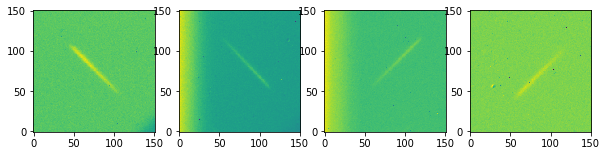

In [16]:
wp_source.get_cutouts(calibrated_data.full_image, calibrated_data.DQ_image, calibrated_data.filter_name, 
                      replace_bad_pixels = True, sub_bar = False, cutout_size = 75)

#plot the traces
fig, ax = plt.subplots(1,4,figsize = (10,4))
for i in range(4):
    ax[i].imshow(wp_source.trace_images[i], origin = 'lower')

## Step 3-4: Background subtraction and spectral extraction ##
In this step we will subtract background and extract the specta from one of the source objects we found in Step 2. Options for the spectral extraction function is pretty extensive, but here are all you need to care about:

__sub_background__ is the background subtraction scheme. 'shift' here is just using shifted background for subtraction. You will notice two negative traces resulting from this. The __bkg_sub_shift_size__ and __shift_dir__ flags are just the amount of shift to apply and the direction. 

__method__ is how we exactly extract the spectra. We are using optimal extraction here and you can read about it in Horne 1986. __spatial_sigma__ is how far in the wing of the spectral trace we want to extract. 


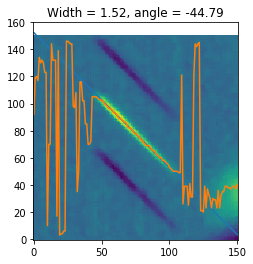

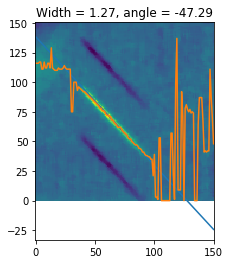

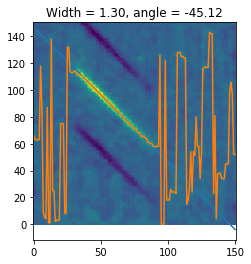

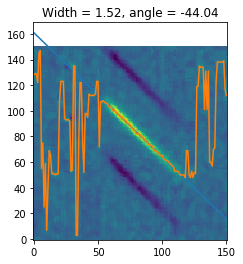

In [17]:
calibrated_data.source_list[0].extract_spectra(plot=False, 
                                   sub_background='shift', 
                                   bkg_sub_shift_size = 41,
                                   shift_dir = 'vertical',
                                   method="optimal_extraction", 
                                   spatial_sigma=10,
                                   bad_pix_masking = 1,
                                   plot_optimal_extraction = False,
                                   plot_findTrace = True,
                                   verbose=False)

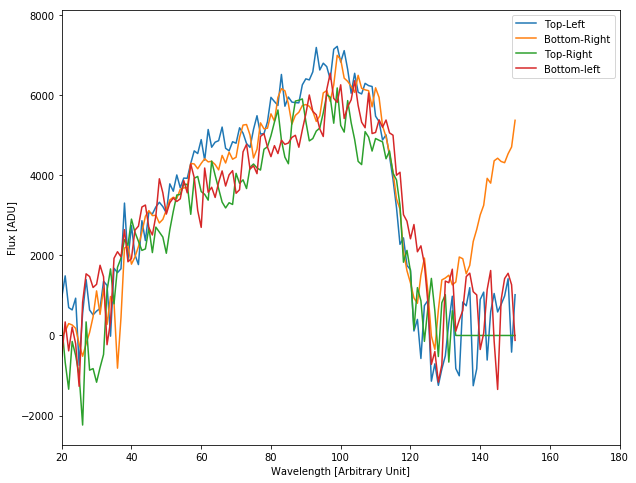

In [18]:
#And we'll plot the data!
calibrated_data.source_list[0].plot_trace_spectra(figsize=(10,8), xlow = 20, xhigh = 180)

Now we'll do a rough wavelength calibration. Currently it uses the edge of the filters to shift and scale the spectra. 

In [19]:
# ## Now we'll do a rough wavelength calibration and plot the data again
# calibrated_data.source_list[0].rough_lambda_calibration(method=2) 
# #Note method=1 is broken. 

# #And we'll plot the data again. 
# calibrated_data.source_list[0].plot_trace_spectra(figsize=(10,6),xlow=1.16,xhigh=1.34)

## Now with Steps 2-4 demonstrated for one file, let's run it all on all files. 


### First with the unpolarized standard star

Extracting from file 1 of 3


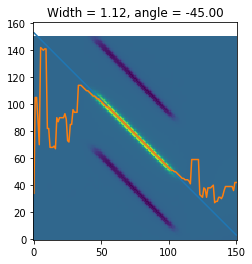

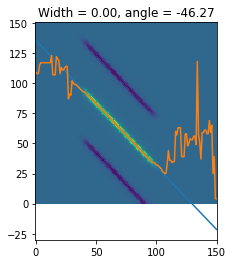

/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:489: RuntimeWarning: divide by zero encountered in true_divide
  P_0 = (data - background)/flux_0 #this is dividing each column (x) in data-background by the sum in that column
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:489: RuntimeWarning: invalid value encountered in true_divide
  P_0 = (data - background)/flux_0 #this is dividing each column (x) in data-background by the sum in that column
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:495: RuntimeWarning: invalid value encountered in less
  P_0[P_0 < 0] = 0
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:497: RuntimeWarning: invalid value encountered in true_divide
  P_0 = P_0/P_sum
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:550: RuntimeWarning: invalid value encountered in multiply
  Mask = (data - background - flux_0*P_0)**2 < sig_clip**2*variance_opt
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/util

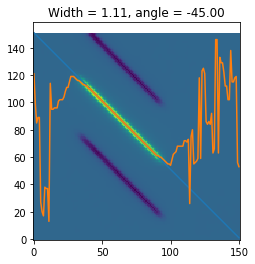

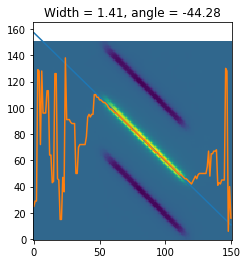

/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:1472: RuntimeWarning: invalid value encountered in true_divide
  corr = fftconvolve(np.nan_to_num(ref/np.nanmax(ref)), np.nan_to_num((up_spec/np.nanmax(up_spec))[::-1]) )#j[1,:] is the flux vector


[ 1.45054951  1.1462085   1.57785162  2.09652736]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0140_calib.fits


Extracting from file 2 of 3


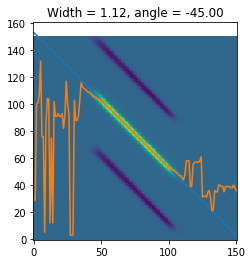

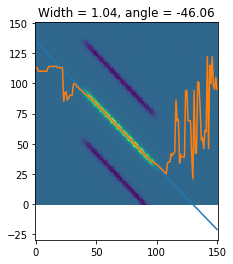

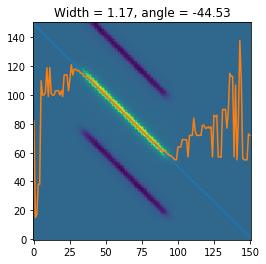

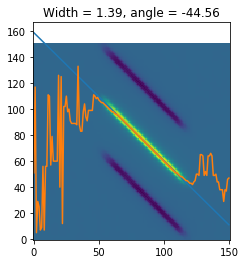

[ 1.60374357  1.32544433  1.57915359  2.04211791]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0141_calib.fits


Extracting from file 3 of 3


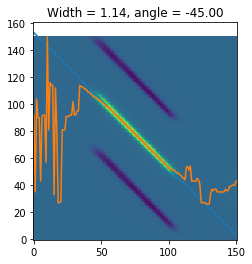

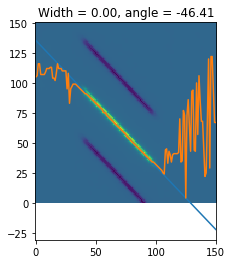

/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:489: RuntimeWarning: divide by zero encountered in true_divide
  P_0 = (data - background)/flux_0 #this is dividing each column (x) in data-background by the sum in that column
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:489: RuntimeWarning: invalid value encountered in true_divide
  P_0 = (data - background)/flux_0 #this is dividing each column (x) in data-background by the sum in that column
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:495: RuntimeWarning: invalid value encountered in less
  P_0[P_0 < 0] = 0
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:497: RuntimeWarning: invalid value encountered in true_divide
  P_0 = P_0/P_sum
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:550: RuntimeWarning: invalid value encountered in multiply
  Mask = (data - background - flux_0*P_0)**2 < sig_clip**2*variance_opt
/Users/kaew/work/wircpol/wirc_drp/wirc_drp/util

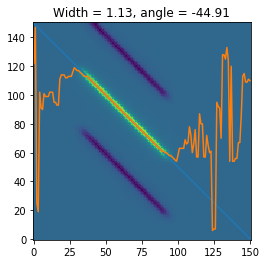

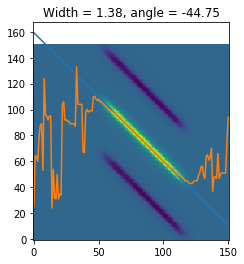

/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:1472: RuntimeWarning: invalid value encountered in true_divide
  corr = fftconvolve(np.nan_to_num(ref/np.nanmax(ref)), np.nan_to_num((up_spec/np.nanmax(up_spec))[::-1]) )#j[1,:] is the flux vector


[ 1.69239908  1.24050483  1.52216223  2.04532082]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0142_calib.fits


In [20]:
source_list = []
all_spec_cube = []
counter = 0
for i,fn in enumerate(unpol_calibrated_list): 
    try:
        print("Extracting from file {} of {}".format(counter+1, len(unpol_calibrated_list)))
        data = wo.wirc_data(wirc_object_filename=fn, verbose=False)
        im = np.array(data.full_image).copy()
        #Clear the source list
        data.source_list = []
        data.n_sources = 0
        data.add_source( source_coords[0], source_coords[1], slit_pos = "slitless", 
                        update_w_chi2_shift = True, verbose = False)
        #Let's save ourselves from million plots
        do_plot = True
        #Get cutouts of the 4 spectra and plot them for every 10 frames
        data.source_list[0].get_cutouts(data.full_image, data.DQ_image, data.filter_name, replace_bad_pixels = True, 
                                        sub_bar = False, cutout_size = 75)
#         if do_plot == True:
#             data.source_list[0].plot_cutouts(origin ='lower')
        #Now extract the spectra
        data.source_list[0].extract_spectra(plot=False, sub_background='shift', 
                                            bkg_poly_order = 1,bkg_sub_shift_size = 41,
                                   method="optimal_extraction", 
                                   bad_pix_masking =1,
                                   plot_optimal_extraction = False,
                                    plot_findTrace = do_plot,
                                   verbose=False, spatial_sigma=10,shift_dir = 'vertical')
        #Save the spectra in this array
        all_spec_cube.append(data.source_list[0].trace_spectra)
        #Save the file
        data.save_wirc_object(fn)
        source_list += [data.source_list[0]]
    except Exception as e:
        print("Some sort of Error, skipping file {}".format(fn))
        print("Error {}".format(e))
    counter += 1
# trace_info = iu.locate_traces(im,sky, plot=False, verbose=True)

source_list = copy.deepcopy(source_list)
up_all_spec_cube = np.array(all_spec_cube)

### Then the brown dwarf

Extracting from file 1 of 3


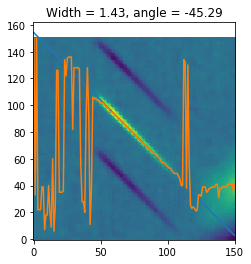

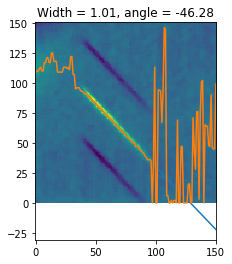

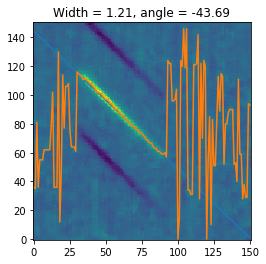

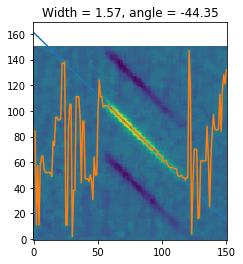

[ 1.85085221  1.44439139  1.73293515  2.07483197]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0158_calib.fits


Extracting from file 2 of 3
[ 2.08543077  2.05486715  1.80669973  2.47997203]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0159_calib.fits


Extracting from file 3 of 3
[ 1.85959135  1.75563087  1.83285256  2.4541058 ]
Saving a wirc_object to /Users/kaew/OneDrive - California Institute of Technology/work/wircpol/wirc_drp/wirc_drp/Tutorial/sample_data/wirc0160_calib.fits


In [21]:
source_list = []
BD_all_spec_cube = []
counter = 0
for i,fn in enumerate(BD_calibrated_list): 
    try:
        print("Extracting from file {} of {}".format(counter+1, len(BD_calibrated_list)))
        data = wo.wirc_data(wirc_object_filename=fn, verbose=False)
        im = np.array(data.full_image).copy()
        #Clear the source list
        data.source_list = []
        data.n_sources = 0
        data.add_source( source_coords[0], source_coords[1], slit_pos = "slitless", 
                        update_w_chi2_shift = True, verbose = False)
        #Let's save ourselves from million plots
        if i%10 == 0:
            do_plot = True
        else:
            do_plot = False
            
        #Get cutouts of the 4 spectra and plot them for every 10 frames
        data.source_list[0].get_cutouts(data.full_image, data.DQ_image, data.filter_name, replace_bad_pixels = True, 
                                        sub_bar = False, cutout_size = 75)
#         if do_plot == True:
#             data.source_list[0].plot_cutouts(origin ='lower')
        #Now extract the spectra
        data.source_list[0].extract_spectra(plot=False, sub_background='shift', 
                                            bkg_poly_order = 1,bkg_sub_shift_size = 41,
                                   method="optimal_extraction", 
                                   bad_pix_masking =1,
                                   plot_optimal_extraction = False,
                                    plot_findTrace = do_plot,
                                   verbose=False, spatial_sigma=10,shift_dir = 'vertical')
        #Save the spectra in this array
        BD_all_spec_cube.append(data.source_list[0].trace_spectra)
        #Save the file
        data.save_wirc_object(fn)
        source_list += [data.source_list[0]]
    except Exception as e:
        print("Some sort of Error, skipping file {}".format(fn))
        print("Error {}".format(e))
    counter += 1
# trace_info = iu.locate_traces(im,sky, plot=False, verbose=True)

source_list = copy.deepcopy(source_list)
BD_up_all_spec_cube = np.array(BD_all_spec_cube)

## Step 5 - Stack the spectra ##

Here we simply align spectra from all the exposures, scale and median combine them. 

In [22]:
up_aligned_cube = su.align_spectral_cube(up_all_spec_cube)
up_scaled_cube = su.scale_and_combine_spectra(up_aligned_cube, return_scaled_cube = True)

/Users/kaew/work/wircpol/wirc_drp/wirc_drp/utils/spec_utils.py:1565: RuntimeWarning: invalid value encountered in true_divide
  scale_factor = total_flux/np.sum(median_filter(four_specs[:,xmin:xmax],size = (1,smooth_size) ), axis = 1) #median filter to remove contributions from noisy wings


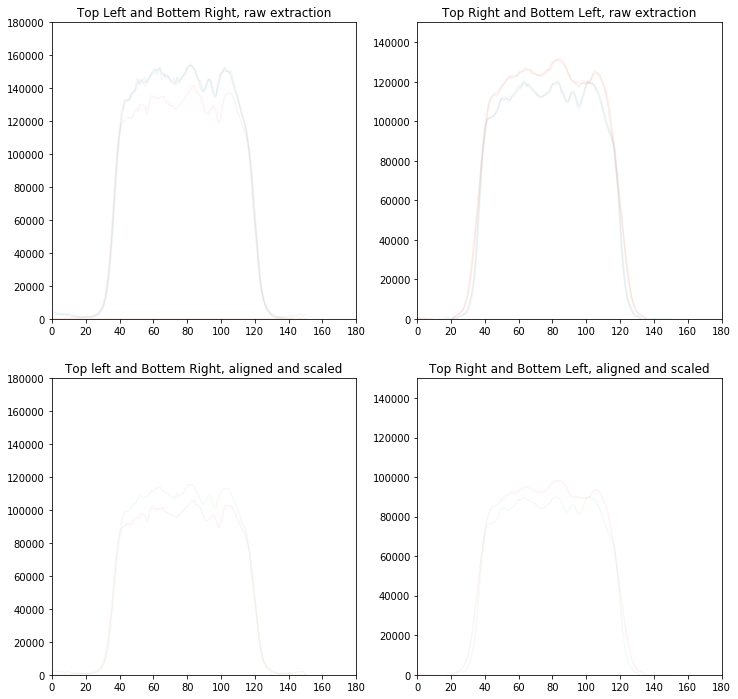

In [23]:
#Plot them. The top plots are raw extraction, bottom are aligned and scaled. 
#The left plots are upper left, lower right (U pair), and right plots are Q pair.
### What do the spectra look like
fig, ax = plt.subplots(2,2,figsize=(12,12))
low_ind =  0
high_ind = 180

cm1 = plt.get_cmap('bwr')
cm2 = plt.get_cmap('copper')
alpha = 0.05

for i in range(up_all_spec_cube.shape[0]):
    ax[0,0].plot(up_all_spec_cube[i,0,1,:], alpha = alpha) #top left
    ax[0,0].plot(up_all_spec_cube[i,1,1,:], alpha = alpha) #bottom right
    ax[0,1].plot(up_all_spec_cube[i,2,1,:], alpha = alpha) #top right
    ax[0,1].plot(up_all_spec_cube[i,3,1,:], alpha = alpha) #bottom left

    #aligned and scaled cube
    ax[1,0].plot(up_scaled_cube[i,0,1,:], alpha = alpha) #top left
    ax[1,0].plot(up_scaled_cube[i,1,1,:], alpha = alpha) #bottom right
    ax[1,1].plot(up_scaled_cube[i,2,1,:], alpha = alpha) #top right
    ax[1,1].plot(up_scaled_cube[i,3,1,:], alpha = alpha) #bottom left
    
ax[0,0].set_xlim([low_ind, high_ind])
ax[0,1].set_xlim([low_ind, high_ind])
ax[1,0].set_xlim([low_ind, high_ind])
ax[1,1].set_xlim([low_ind, high_ind])
ax[0,0].set_ylim([0, 180000])
ax[0,1].set_ylim([0, 150000])
ax[1,0].set_ylim([0, 180000])
ax[1,1].set_ylim([0, 150000])


ax[0,0].set_title('Top Left and Bottem Right, raw extraction')
ax[0,1].set_title('Top Right and Bottem Left, raw extraction')
ax[1,0].set_title('Top left and Bottem Right, aligned and scaled')
ax[1,1].set_title('Top Right and Bottem Left, aligned and scaled')

We can now median combine and compute standard deviation of the measurement. 

Each trace corresponds to Stokes parameters as following: Qp -- Bottom left; Qm -- Top right; Up -- Bottom right; Um -- Top left. 

These are such that normalized Stokes parameters are q = (Qp - Qm)/(Qp + Qm) and u = (Up - Um)/(Up + Um)

In [24]:
sshift_um = 0
sshift_up = -2.2
sshift_qm = +0.7
sshift_qp = -2.5

unpol_um_med = shift(np.nanmedian(up_scaled_cube[:,0,1,:], axis=0),sshift_um, order = 1)
unpol_up_med = shift(np.nanmedian(up_scaled_cube[:,1,1,:], axis=0),sshift_up, order = 1)
unpol_qm_med = shift(np.nanmedian(up_scaled_cube[:,2,1,:], axis=0),sshift_qm, order = 1)
unpol_qp_med = shift(np.nanmedian(up_scaled_cube[:,3,1,:], axis=0),sshift_qp, order = 1)

unpol_um_std = shift(np.nanstd(up_scaled_cube[:,0,1,:], axis=0)/np.sqrt(up_scaled_cube.shape[0]),sshift_um, order = 1)
unpol_up_std = shift(np.nanstd(up_scaled_cube[:,1,1,:], axis=0)/np.sqrt(up_scaled_cube.shape[0]),sshift_up, order = 1)
unpol_qm_std = shift(np.nanstd(up_scaled_cube[:,2,1,:], axis=0)/np.sqrt(up_scaled_cube.shape[0]),sshift_qm, order = 1)
unpol_qp_std = shift(np.nanstd(up_scaled_cube[:,3,1,:], axis=0)/np.sqrt(up_scaled_cube.shape[0]),sshift_qp, order = 1)

In [25]:
# Most manual step here is to make sure the 4 spectra are aligned in wavelength. The offsets given above are good, 
# but let's plot them to check.

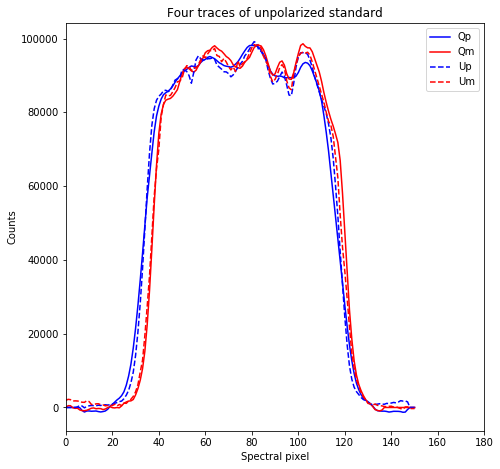

In [26]:
plt.figure(figsize = (7.5,7.5))
vector = [unpol_qp_med,unpol_qm_med,unpol_up_med,unpol_um_med]
labels = ['Qp','Qm','Up','Um']
factors = np.sum(unpol_qp_med[50:110])/np.array([np.sum(x[50:110]) for x in vector])
factors[1] = factors[1]*1.015
factors[2] = factors[2]*0.995
factors[3] = factors[3]*1.005
fmts =   ['-b','-r','--b','--r']
for i in range(len(vector)):
    plt.plot(vector[i]*factors[i],fmts[i], label = labels[i])
# plt.xlim([low_ind, high_ind])
plt.xlim([low_ind, high_ind])
plt.xlim([0,180])
#plt.ylim([100000,140000])
plt.xlabel('Spectral pixel')
plt.ylabel('Counts')
plt.legend()
plt.title('Four traces of unpolarized standard')

## Now you do the same for the brown dwarf

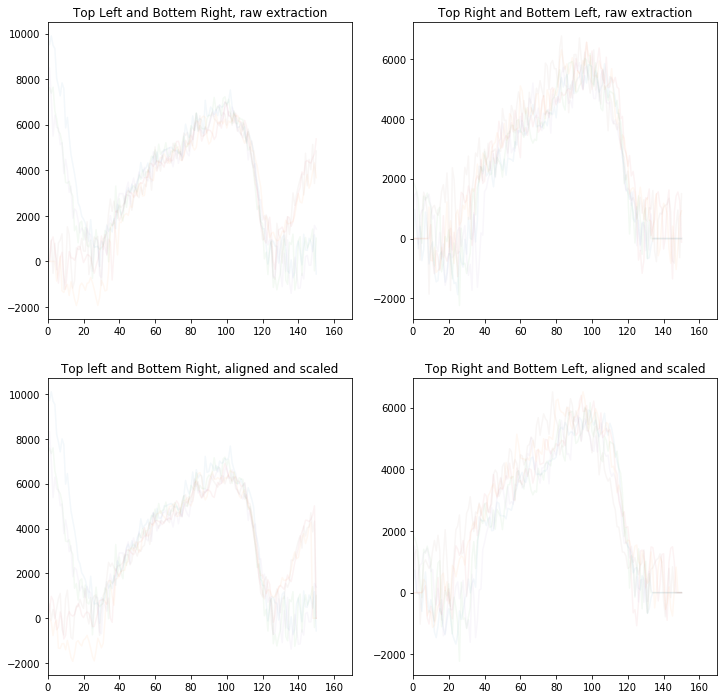

In [27]:
BD_up_aligned_cube = su.align_spectral_cube(BD_up_all_spec_cube)
BD_up_scaled_cube = su.scale_and_combine_spectra(BD_up_aligned_cube, return_scaled_cube = True)

fig1, ax1 = plt.subplots(2,2,figsize=(12,12))
low_ind =  0
high_ind = 170

cm1 = plt.get_cmap('bwr')
cm2 = plt.get_cmap('copper')
alpha = 0.05

for i in range(BD_up_all_spec_cube.shape[0]):
    ax1[0,0].plot(BD_up_all_spec_cube[i,0,1,:], alpha = alpha) #top left
    ax1[0,0].plot(BD_up_all_spec_cube[i,1,1,:], alpha = alpha) #bottom right
    ax1[0,1].plot(BD_up_all_spec_cube[i,2,1,:], alpha = alpha) #top right
    ax1[0,1].plot(BD_up_all_spec_cube[i,3,1,:], alpha = alpha) #bottom left

    #aligned and scaled cube
    ax1[1,0].plot(BD_up_scaled_cube[i,0,1,:], alpha = alpha) #top left
    ax1[1,0].plot(BD_up_scaled_cube[i,1,1,:], alpha = alpha) #bottom right
    ax1[1,1].plot(BD_up_scaled_cube[i,2,1,:], alpha = alpha) #top right
    ax1[1,1].plot(BD_up_scaled_cube[i,3,1,:], alpha = alpha) #bottom left
    
ax1[0,0].set_xlim([low_ind, high_ind])
ax1[0,1].set_xlim([low_ind, high_ind])
ax1[1,0].set_xlim([low_ind, high_ind])
ax1[1,1].set_xlim([low_ind, high_ind])
#ax1[0,0].set_ylim([0, 180000])
#ax1[0,1].set_ylim([0, 150000])
#ax1[1,0].set_ylim([0, 180000])
#ax1[1,1].set_ylim([0, 150000])


ax1[0,0].set_title('Top Left and Bottem Right, raw extraction')
ax1[0,1].set_title('Top Right and Bottem Left, raw extraction')
ax1[1,0].set_title('Top left and Bottem Right, aligned and scaled')
ax1[1,1].set_title('Top Right and Bottem Left, aligned and scaled')



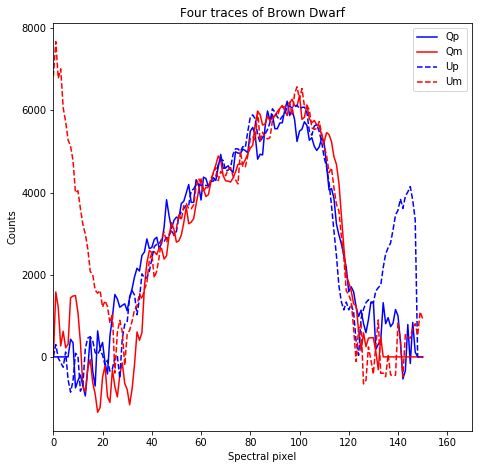

In [28]:
#now shifts for the BD spectra 
sshift_um = 0
sshift_up = -2.2
sshift_qm = +0.7
sshift_qp = +1

BD_um_med = shift(np.nanmedian(BD_up_scaled_cube[:,0,1,:], axis=0),sshift_um, order = 1)
BD_up_med = shift(np.nanmedian(BD_up_scaled_cube[:,1,1,:], axis=0),sshift_up, order = 1)
BD_qm_med = shift(np.nanmedian(BD_up_scaled_cube[:,2,1,:], axis=0),sshift_qm, order = 1)
BD_qp_med = shift(np.nanmedian(BD_up_scaled_cube[:,3,1,:], axis=0),sshift_qp, order = 1)

BD_um_std = shift(np.nanstd(BD_up_scaled_cube[:,0,1,:], axis=0)/np.sqrt(BD_up_scaled_cube.shape[0]),sshift_um, order = 1)
BD_up_std = shift(np.nanstd(BD_up_scaled_cube[:,1,1,:], axis=0)/np.sqrt(BD_up_scaled_cube.shape[0]),sshift_up, order = 1)
BD_qm_std = shift(np.nanstd(BD_up_scaled_cube[:,2,1,:], axis=0)/np.sqrt(BD_up_scaled_cube.shape[0]),sshift_qm, order = 1)
BD_qp_std = shift(np.nanstd(BD_up_scaled_cube[:,3,1,:], axis=0)/np.sqrt(BD_up_scaled_cube.shape[0]),sshift_qp, order = 1)

plt.figure(figsize = (7.5,7.5))
vector = [BD_qp_med,BD_qm_med,BD_up_med,BD_um_med]
labels = ['Qp','Qm','Up','Um']
factors = np.sum(BD_qp_med[40:120])/np.array([np.sum(x[40:120]) for x in vector])
factors[1] = factors[1]*1.015
factors[2] = factors[2]*0.995
factors[3] = factors[3]*1.005
fmts =   ['-b','-r','--b','--r']
for i in range(len(vector)):
    plt.plot(vector[i]*factors[i],fmts[i], label = labels[i])
# plt.xlim([low_ind, high_ind])
plt.xlim([low_ind, high_ind])
#plt.xlim([160,180])
#plt.ylim([100000,140000])
plt.xlabel('Spectral pixel')
plt.ylabel('Counts')
plt.legend()
plt.title('Four traces of Brown Dwarf')

# Step 6: Polarization calibration and calculation

Suggestions: The most crucial part here is to get wavelength to line up. This is a bit tricky since WIRC+Pol is slitless and there's no easy way to get wavelength solution directly from the data. 

We suggest that you align the brown dwarf spectra to those of the standard star __trace by trace__ relying on the filter cutoffs. Note that different traces have difference filter cutoff.

From the last part, you would have the median spectra: unpol_qp_med, unpol_qm_med and pol_qp_med, pol_qm_med from the standard and the brown dwarf respectively. 

In [29]:
#First compute q, u from the unpolarized star. This is the instrumental polarization
import math
import numpy as np

q_inst = (unpol_qp_med - unpol_qm_med)/(unpol_qp_med + unpol_qm_med)
u_inst = (unpol_up_med - unpol_um_med)/(unpol_up_med + unpol_um_med)

# Uncertainties, fill this in!

q_inst_err = 2/(unpol_qp_med+unpol_qm_med)**2*np.sqrt((unpol_qp_med*unpol_qm_std)**2 + (unpol_qm_med*unpol_qp_std)**2 )
u_inst_err = 2/(unpol_up_med+unpol_um_med)**2*np.sqrt((unpol_up_med*unpol_um_std)**2 + (unpol_um_med*unpol_up_std)**2 )

/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


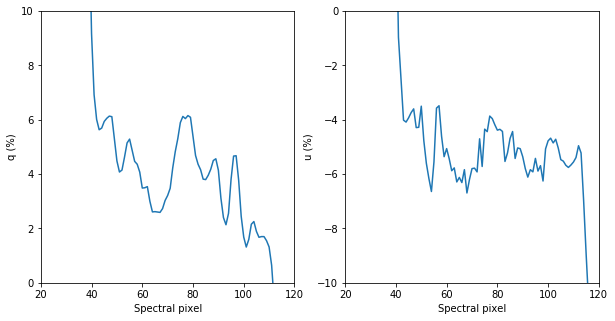

In [30]:
#show this

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(q_inst*100)
ax[1].plot(u_inst*100)

ax[0].set_xlim([20,120])
ax[1].set_xlim([20,120])
ax[0].set_ylim([-0,10])
ax[1].set_ylim([-10,0])

ax[0].set_xlabel('Spectral pixel')
ax[1].set_xlabel('Spectral pixel')

ax[0].set_ylabel('q (%)')
ax[1].set_ylabel('u (%)')

In [31]:
#### Do the same for the Brown Dwarf ####

In [32]:
q_BD_raw = (BD_qp_med - BD_qm_med)/(BD_qp_med + BD_qm_med)
u_BD_raw = (BD_up_med - BD_um_med)/(BD_up_med + BD_um_med)

# Uncertainties, fill this in!

q_BD_raw_err = 2/(BD_qp_med+BD_qm_med)**2*np.sqrt((BD_qp_med*BD_qm_std)**2 + (BD_qm_med*BD_qp_std)**2 )
u_BD_raw_err = 2/(BD_up_med+BD_um_med)**2*np.sqrt((BD_up_med*BD_um_std)**2 + (BD_um_med*BD_up_std)**2 )

#Now subtract the instrumental polarization 
q_BD_corrected =  q_BD_raw - q_inst
u_BD_corrected =  u_BD_raw - u_inst

q_BD_corrected_err = np.sqrt(q_BD_raw_err**2 + q_inst_err**2)
u_BD_corrected_err = np.sqrt(u_BD_raw_err**2 + u_inst_err**2)

/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/Users/kaew/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


<Container object of 3 artists>

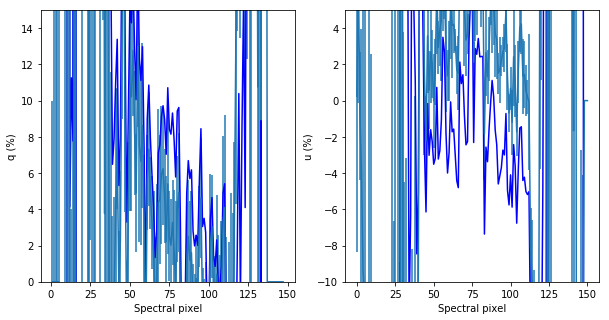

In [33]:
### Plot q_BD_raw, q_BD_corrected here

fig, ax = plt.subplots(1,2, figsize = (10,5))

x = range(len(q_BD_raw)) 
ax[0].plot(x,q_BD_raw*100,'-b')
#ax[0].plot(q_BD_corrected*100,'-r')

ax[1].plot(x,u_BD_raw*100,'b-')
#ax[1].plot(u_BD_corrected*100,'-r')

#ax[0].set_xlim([100,200])
#ax[1].set_xlim([100,200])
ax[0].set_ylim([-0,15])
ax[1].set_ylim([-10,5])

ax[0].set_xlabel('Spectral pixel')
ax[1].set_xlabel('Spectral pixel')

ax[0].set_ylabel('q (%)')
ax[1].set_ylabel('u (%)')

#q here
ax[0].errorbar(x,q_BD_corrected*100,yerr=q_BD_corrected_err*100)
#u here
ax[1].errorbar(x,u_BD_corrected*100,yerr=u_BD_corrected_err*100)

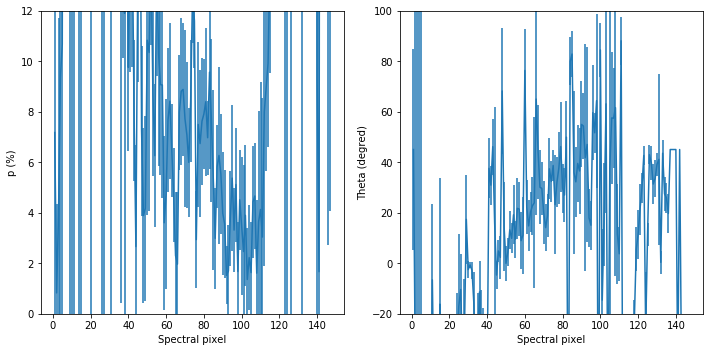

In [40]:
#### Finally, compute degree and angle of polarization

p = np.sqrt(q_BD_corrected**2 + u_BD_corrected**2)
theta = 0.5*np.arctan2(u_BD_corrected, q_BD_corrected)

#uncertainties

p_err = (1/p)*np.sqrt((q_BD_corrected*q_BD_corrected_err)**2 + (u_BD_corrected*u_BD_corrected_err)**2)
# theta_err = (0.5/(1+(u_BD_corrected/q_BD_corrected)**2))*np.sqrt((u_BD_corrected_err/q_BD_corrected)**2 + (u_BD_corrected*q_BD_corrected_err/(q_BD_corrected**2))**2)
theta_err = (0.5/p**2)*np.sqrt((q_BD_corrected*u_BD_corrected_err)**2 + (u_BD_corrected*q_BD_corrected_err)**2)

#plot these!

fig, ax = plt.subplots(1,2, figsize = (10,5))

x = range(len(q_BD_raw)) 
# ax[0].plot(x,p*100,'-b')
# ax[1].plot(x,theta,'b-')
#ax[1].plot(u_BD_corrected*100,'-r')

#ax[0].set_xlim([100,200])
#ax[1].set_xlim([100,200])
ax[0].set_ylim([-0,12])
ax[1].set_ylim([-20,100])

ax[0].set_xlabel('Spectral pixel')
ax[1].set_xlabel('Spectral pixel')

ax[0].set_ylabel('p (%)')
ax[1].set_ylabel('Theta (degred)')

#q here
ax[0].errorbar(x,p*100,yerr=p_err*100)
#u here
ax[1].errorbar(x,np.degrees(theta),yerr=np.degrees(theta_err))
plt.tight_layout()

# Acknowledgement

The data used in this Tutorial are taken by the Ay122a class in Fall 2018 with Prof. Dimitri Mawet. Class members are Aida, Anise, Anusha, Luiza, Nitika, Ryan, Yuhan, Yuping, Zhihui, and TA Jackie Pezzato. They contributed to making this Tutorial as well. 